# Project 1: Wine Dataset Part 4 - Comparing Weight Initialization Methods

### Brief Project Description

In this project, we compare two weight initialization methods, Kaiming and Xavier, using the wine dataset. After conducting the experiment, we evaluate the results through T-tests.

In [122]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import scipy.stats as stas

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import warnings
warnings.filterwarnings("ignore")

# Import and Process the Data

In [123]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

In [124]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Now for the DL part

In [125]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

# A Function to Train the Model

In [126]:
# global parameter
numepochs = 600

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

# Run a Model Example

In [127]:
# create a new Kaming model instance
winenet = ANNwine()

trainAccKaming,testAccKaming,lossesKaming = trainTheModel()


# create a new Xavier model instance
winenet = ANNwine()

for p in winenet.named_parameters():
    if 'weights' in p[0]:
        nn.init.xavier_normal_(p[1].data)

trainAccXavier,testAccXavier,lossesXavier = trainTheModel()

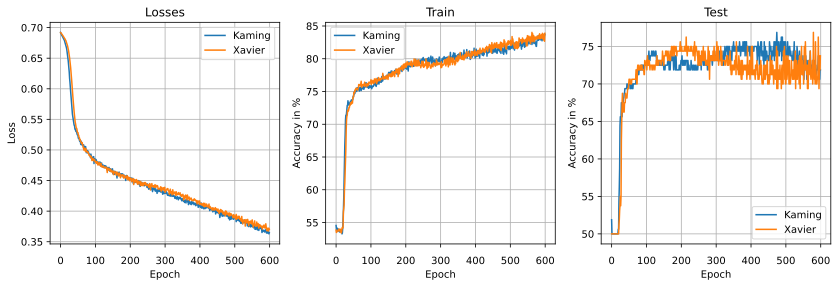

In [128]:
fig, ax = plt.subplots(1,3,figsize=(14,4))

# plot the losses
ax[0].plot(range(numepochs),lossesKaming)
ax[0].plot(range(numepochs),lossesXavier)
ax[0].set_title('Losses')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Kaming', 'Xavier'])
ax[0].grid(True)

# plot the train
ax[1].plot(range(numepochs),trainAccKaming)
ax[1].plot(range(numepochs),trainAccXavier)
ax[1].set_title('Train')
ax[1].set_ylabel('Accuracy in %')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Kaming', 'Xavier'])
ax[1].grid(True)

# plot the train
ax[2].plot(range(numepochs),testAccKaming)
ax[2].plot(range(numepochs),testAccXavier)
ax[2].set_title('Test')
ax[2].set_ylabel('Accuracy in %')
ax[2].set_xlabel('Epoch')
ax[2].legend(['Kaming', 'Xavier'])
ax[2].grid(True)

plt.show()



# Run the Experiment

In [129]:
# initialize result matricies
resultsXavier = np.zeros((10,10,10))
resultsKaming = np.zeros((10,10,10))

# create 10 instances of the model

for i in range(0,10):
    
    print(f'Train Xavier Model {i+1}')
    
    # create a new Xavier model instance
    winenet = ANNwine()

    for p in winenet.named_parameters():
        if 'weight' in p[0]:
            nn.init.xavier_normal_(p[1].data)

    trainAcc,testAcc,losses = trainTheModel()
    
    # store the results for the Xavier model
    resultsXavier[i, 0, 0] = trainAcc[-1]
    resultsXavier[0, i, 0] = testAcc[-1]
    resultsXavier[0, 0, i] = losses[-1]
    
    print(f'Train Kamien Model {i+1}')
    
     # create a new Kamien model instance
    winenet = ANNwine()

    trainAcc,testAcc,losses = trainTheModel()
    
     # store the results for the Xavier model
    resultsKaming[i, 0, 0] = trainAcc[-1]
    resultsKaming[0, i, 0] = testAcc[-1]
    resultsKaming[0, 0, i] = losses[-1]

Train Xavier Model 1
Train Kamien Model 1
Train Xavier Model 2
Train Kamien Model 2
Train Xavier Model 3
Train Kamien Model 3
Train Xavier Model 4
Train Kamien Model 4
Train Xavier Model 5
Train Kamien Model 5
Train Xavier Model 6
Train Kamien Model 6
Train Xavier Model 7
Train Kamien Model 7
Train Xavier Model 8
Train Kamien Model 8
Train Xavier Model 9
Train Kamien Model 9
Train Xavier Model 10
Train Kamien Model 10


## Conduct a T-test

We perform a T-test to compare the means of two independent samples of scores. One set of scores corresponds to the results (losses, train accuracy, test accuracy) obtained using the Kaiming method, while the other set corresponds to the results obtained using the Xavier method.

This is a test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default.

In [131]:
# perform a t-tests via stats package

def hypothesisCheck(p):
    
    alpha = 0.05
    
    if p > alpha:
        print('   Kaming == Xavgier (fail to reject H0) \n')
    else:
        print('   Kaming != Xavier (reject H0) \n')

# t-test to asses the difference between the losses for the Kamien and Xavier models
t_loss, p_loss = stats.ttest_ind(resultsKaming[0, 0, :], resultsXavier[0, 0, :] )
print(f'Hypothesis check for losses: \n')
hypothesisCheck(p_loss)


# t-test to asses the difference between the train accuracy for the Kamien and Xavier models
t_train, p_train = stats.ttest_ind(resultsKaming[:, 0, 0], resultsXavier[:, 0, 0] )
print(f'Hypothesis check for train accuracy: \n')
hypothesisCheck(p_train)


# t-test to asses the difference between the test accuracy for the Kamien and Xavier models
t_test, p_test = stats.ttest_ind(resultsKaming[0, 0, :], resultsXavier[0, 0, :] )
print(f'Hypothesis check for test accuracy: \n')
hypothesisCheck(p_test)


Hypothesis check for losses: 

   Kaming != Xavier (reject H0) 

Hypothesis check for train accuracy: 

   Kaming == Xavgier (fail to reject H0) 

Hypothesis check for test accuracy: 

   Kaming != Xavier (reject H0) 



## Plot the Results

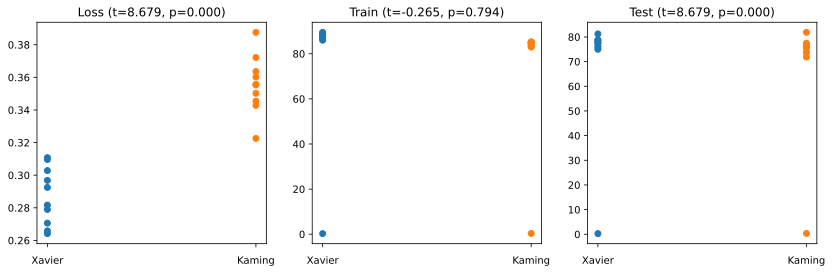

In [132]:
fig, ax = plt.subplots(1,3,figsize=(14,4))

# plot the losses
ax[0].scatter(np.zeros(10), resultsXavier[0, 0, :] )
ax[0].scatter(np.ones(10), resultsKaming[0, 0, :] )
ax[0].set_xticks([0,1], labels=['Xavier','Kaming'])
ax[0].set_title(f'Loss (t={t_loss:.3f}, p={p_loss:.3f})')

# plot the train accuracy
ax[1].scatter(np.zeros(10), resultsXavier[:, 0, 0] )
ax[1].scatter(np.ones(10), resultsKaming[:, 0, 0] )
ax[1].set_xticks([0,1], labels=['Xavier','Kaming'])
ax[1].set_title(f'Train (t={t_train:.3f}, p={p_train:.3f})')

# plot the train accuracy
ax[2].scatter(np.zeros(10), resultsXavier[0, :, 0] )
ax[2].scatter(np.ones(10), resultsKaming[0, :, 0] )
ax[2].set_xticks([0,1], labels=['Xavier','Kaming'])
ax[2].set_title(f'Test (t={t_test:.3f}, p={p_test:.3f})')
plt.show()

# Reference:
    
https://www.udemy.com/course/deeplearning_x/